# 像搭积木一样搭神经网络

In [1]:
EBD_PATH = './data/imdb_embedding_100.csv'
BATCH_SIZE = 6

In [2]:
import math
import random
import copy
import numpy as np
import torch
from torch import nn
import util

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 一、概述

### 1.2 DataLoader

In [3]:
class DataLoader:
    def __init__(self, data: list, batch_size: int):
        self.i = 0
        self.batch_size = batch_size
        self.batch_num = math.floor(len(data) / batch_size)
        self._data = self.gen_batch(data)

    def gen_batch(self, data):
        lst = []
        s = self.batch_size
        for i in range(self.batch_num):
            start, end = s * i, s * (i + 1)
            X = torch.tensor([e[0] for e in data[start:end]])
            y = torch.tensor([e[1] for e in data[start:end]])
            lst.append((X, y))

        return lst

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):
        if self.i < len(self._data):
            self.i += 1
            return self._data[self.i - 1]
        else:
            raise StopIteration

假设有二元函数：

$$f(a, b) = \frac{a^2 - b^2}{a^2 + b^2} + \epsilon$$

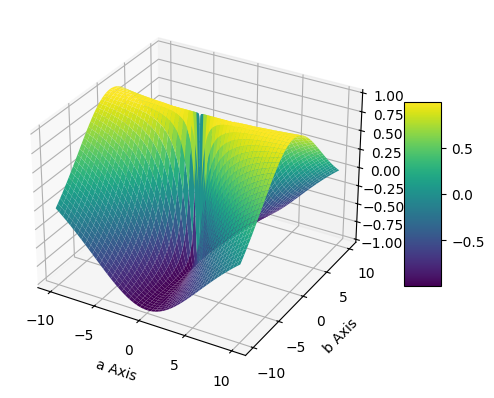

In [4]:
a, b = np.meshgrid(np.linspace(-10, 10, 1000), np.linspace(-10, 10, 1000))
y = np.where((a**2 + b**2) != 0, (a**2 - b**2) / (a**2 + b**2), np.nan)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(a, b, y, cmap='viridis')

fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('a Axis')
ax.set_ylabel('b Axis')
ax.set_zlabel('y Axis')
plt.show()

In [5]:
# 构造符合 f(a, b) = \frac{a^2 - b^2}{a^2 + b^2} + \epsilon 函数的样本生成
sample_num, batch_size = 2560, 10
X = [(random.random(), random.random()) for e in range(sample_num)]
y = map(lambda e: ((e[0]**2 - e[1]**2) / (e[0]**2 + e[1]**2)) + (random.random() / 100), X)

raw_data = list(zip(X, y))

In [6]:
# 输出一个批量的数据
for X, y in DataLoader(data=raw_data, batch_size=batch_size):
    print(f'X: {X}')
    print(f'y: {y}')
    break

X: tensor([[0.0099, 0.3906],
        [0.2993, 0.5968],
        [0.2439, 0.0611],
        [0.3627, 0.5524],
        [0.6906, 0.5202],
        [0.0390, 0.4638],
        [0.2873, 0.5687],
        [0.1223, 0.9023],
        [0.4821, 0.1012],
        [0.0726, 0.1562]])
y: tensor([-0.9954, -0.5949,  0.8838, -0.3951,  0.2774, -0.9854, -0.5919, -0.9635,
         0.9219, -0.6352])


## 二、激活函数

### 2.1 Sigmoid

- 表达式：$ sigmoid (x) = \frac{1}{1 + e^{-x}} $
- 值域：$(0, 1)$
- 特性：导数存在且处处可微。但在输入值很大或很小的情况下，梯度接近于零，导致梯度消失的问题。且输出不是零均值，可能会影响下一层的收敛速度。

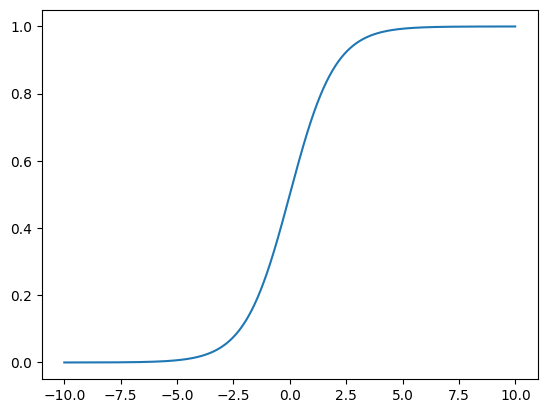

In [7]:
x = np.array([i/100 - 10 for i in range(2000)])
y = 1 / (1 + np.exp(-x))
plt.plot(x, y)

### 2.2 Tanh

- 表达式：$ \tanh(x) = \frac{1 - e^{-2x}}{1 + e^{-2x}} $
- 值域：$(-1, 1)$
- 特性：与 Sigmoid 函数相似，存在梯度消失问题。但相比 Sigmoid 函数，输出值更接近于零均值，有助于加快收敛速度。

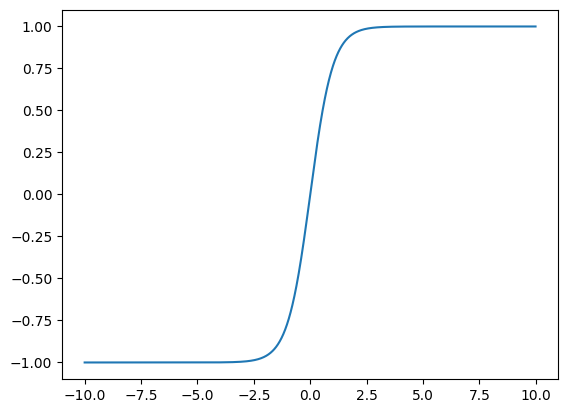

In [8]:
x = np.array([i/100 - 10 for i in range(2000)])
y = (1 - np.exp(-2 * x)) / (1 + np.exp(-2 * x))
plt.plot(x, y)

### 2.3 ReLU

- 表达式：$ ReLU (x) = \max(0, x) $
- 值域：$[0, +\infty)$
- 特性：简单高效，计算速度快。当输入为正数时，梯度为 1，可避免梯度消失问题；当输入为负数时，梯度为 0，意味着不再激活，即神经元死亡。输出不是归一化的，可能需要额外的规范化技术。

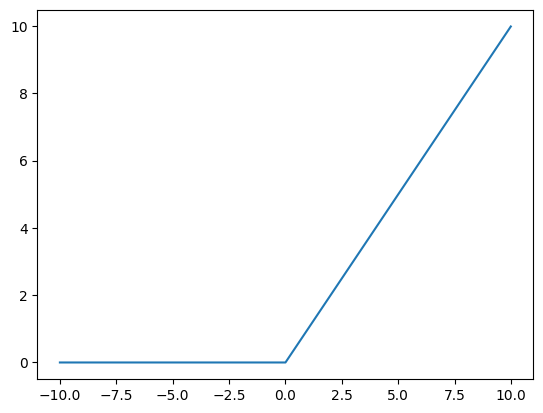

In [9]:
x = [i/100 - 10 for i in range(2000)]
y = [max(e, 0) for e in x]
plt.plot(x, y)

### 2.4 Softmax

- 表达式：$\operatorname{softmax}(\mathbf{X})_{i j}=\frac{\exp \left(\mathbf{X}_{i j}\right)}{\sum_k \exp \left(\mathbf{X}_{i k}\right)}$
- 值域：输出是一个概率分布，所有元素和为 1
- 特性：可将任意实数向量转化为概率分布向量，常用于分类模型输出层的激活函数。

sum(y): 1.0
y: [0.02103, 0.17171, 0.76956, 0.03137, 0.00633]


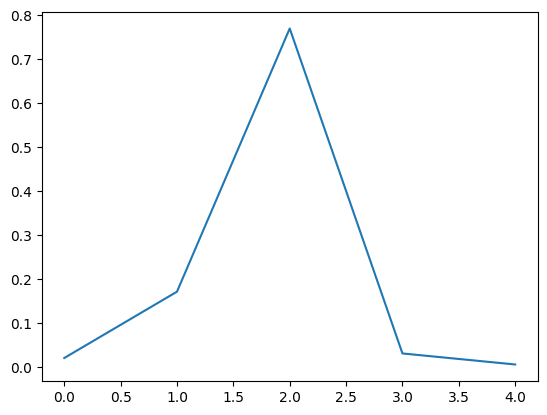

In [10]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

x = torch.tensor([[1.4, 3.5, 5, 1.8, 0.2]])
y = softmax(x)[0]
print(f'sum(y): {sum(y)}')
print(f'y: {[round(e, 5) for e in y.tolist()]}')

plt.plot(list(range(len(y))), y.tolist())
plt.show()

## 三、损失函数

In [11]:
# 加载 embedding
df = util.read_embedding_csv(csv_path=EBD_PATH,
                             ebd_cols=['embedding'])
df = df.drop(['review'], axis=1)
df['sentiment'] = df['sentiment'].apply(lambda e: 1 if e == 'positive' else 0)
df

,sentiment,embedding
0,1,"[0.07209432125091553, -0.13117115199565887, 0...."
1,1,"[-0.029719768092036247, 0.07780290395021439, 0..."
2,1,"[-0.1713847815990448, -0.26116693019866943, 0...."
3,0,"[0.14628827571868896, -0.15408608317375183, 0...."
4,1,"[-0.0845172330737114, 0.0209943950176239, 0.26..."
...,...,...
95,1,"[-0.20295925438404083, 0.03941255435347557, 0...."
96,0,"[0.030739225447177887, -0.07907424122095108, 0..."
97,0,"[0.04264165461063385, -0.005480818450450897, 0..."
98,0,"[0.1504366397857666, -0.09209532290697098, 0.3..."


In [12]:
# 分割训练集和验证集
X = np.stack(df['embedding']).astype(np.float32)
y = np.stack(df['sentiment']).astype(np.int64)
X_train, X_test, y_train, y_test = util.train_test_split(X, y, test_size=0.2)

# 生成数据迭代器
train_iter = util.gen_iter(X=X_train, y=y_train, batch_size=BATCH_SIZE)
test_iter = util.gen_iter(X=X_test, y=y_test, batch_size=BATCH_SIZE)

# 定义一个单隐藏层的 MLP
net = nn.Sequential(nn.Linear(768, 256),
                    nn.ReLU(),
                    nn.Linear(256, 32),
                    nn.ReLU(),
                    nn.Linear(32, 2))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

# 初始化权重
net.apply(init_weights)

# 损失函数：nn.CrossEntropyLoss 包含 softmax 功能
loss = nn.CrossEntropyLoss(reduction='none')

# 优化器
optimizer = torch.optim.Adam(net.parameters())

# 获取各层权重
layers = [e for e in net.children()]
l0, l1, l2 = layers[0], layers[2], layers[4]
W0, W1, W2 = l0.weight, l1.weight, l2.weight

In [13]:
# 将模型设置为训练模式
net.train()

for X, y in train_iter:
    break

# 正向传播
y_hat = net(X)
# 计算损失
l = loss(y_hat, y)

# 保留损失的梯度
l.retain_grad()

# 求损失均值
loss_mean = l.mean()

W0_loss = copy.deepcopy(W0.data)
W1_loss = copy.deepcopy(W1.data)
W2_loss = copy.deepcopy(W2.data)

W0_loss_grad = copy.deepcopy(W0.grad)
W1_loss_grad = copy.deepcopy(W1.grad)
W2_loss_grad = copy.deepcopy(W2.grad)

print(f'X: {X}')
print(f'y: {y}')
print(f'y_hat: {y_hat}')
print(f'loss: {l}')
print(f'loss mean: {l.mean()}')
print(f'loss grad: {l.grad}')
print(f'W0.data: {W0.data}')
print(f'W0.grad: {W0.grad}')
print(f'W1.data: {W1.data}')
print(f'W1.grad: {W1.grad}')
print(f'W2.data: {W2.data}')
print(f'W2.grad: {W2.grad}')

X: tensor([[-0.2261, -0.4410,  0.4004,  ..., -0.0417,  0.3123, -0.1805],
        [-0.1116,  0.1192,  0.2288,  ..., -0.0418,  0.2146,  0.0834],
        [ 0.1064,  0.0288,  0.1501,  ..., -0.0099,  0.2409,  0.0330],
        [ 0.0383, -0.0029,  0.1799,  ..., -0.0596,  0.1671,  0.1119],
        [ 0.0825, -0.0529,  0.1805,  ..., -0.0115,  0.0812,  0.0697],
        [ 0.0112, -0.1510,  0.2971,  ...,  0.0045,  0.2350,  0.0934]])
y: tensor([1, 1, 0, 0, 0, 0])
y_hat: tensor([[-0.0241, -0.1288],
        [-0.0239, -0.1285],
        [-0.0243, -0.1284],
        [-0.0241, -0.1285],
        [-0.0241, -0.1288],
        [-0.0240, -0.1287]], grad_fn=<AddmmBackward0>)
loss: tensor([0.7469, 0.7468, 0.6424, 0.6423, 0.6421, 0.6422],
       grad_fn=<NllLossBackward0>)
loss mean: 0.6771205067634583
loss grad: None
W0.data: tensor([[ 0.0220, -0.0045, -0.0057,  ..., -0.0054,  0.0039, -0.0131],
        [-0.0018, -0.0026,  0.0014,  ..., -0.0080, -0.0096,  0.0015],
        [-0.0048, -0.0019, -0.0127,  ..., -0.0121, 

In [14]:
# 清除梯度
optimizer.zero_grad()

# 反向传播：更新 loss 和 权重的梯度
l.mean().backward()

W0_backward = copy.deepcopy(W0.data)
W1_backward = copy.deepcopy(W1.data)
W2_backward = copy.deepcopy(W2.data)

W0_backward_grad = copy.deepcopy(W0.grad)
W1_backward_grad = copy.deepcopy(W1.grad)
W2_backward_grad = copy.deepcopy(W2.grad)

print(f'loss: {l}')
print(f'loss mean: {l.mean()}')
print(f'loss grad: {l.grad}')
print(f'W0.data: {W0.data}')
print(f'W0.grad: {W0.grad}')
print(f'W1.data: {W1.data}')
print(f'W1.grad: {W1.grad}')
print(f'W2.data: {W2.data}')
print(f'W2.grad: {W2.grad}')
print(f'W0_backward == W0_loss: {torch.equal(W0_backward, W0_loss)}')
print(f'W1_backward == W1_loss: {torch.equal(W1_backward, W1_loss)}')
print(f'W2_backward == W2_loss: {torch.equal(W2_backward, W2_loss)}')

loss: tensor([0.7469, 0.7468, 0.6424, 0.6423, 0.6421, 0.6422],
       grad_fn=<NllLossBackward0>)
loss mean: 0.6771205067634583
loss grad: tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])
W0.data: tensor([[ 0.0220, -0.0045, -0.0057,  ..., -0.0054,  0.0039, -0.0131],
        [-0.0018, -0.0026,  0.0014,  ..., -0.0080, -0.0096,  0.0015],
        [-0.0048, -0.0019, -0.0127,  ..., -0.0121, -0.0034, -0.0008],
        ...,
        [ 0.0048, -0.0088,  0.0140,  ..., -0.0022,  0.0199,  0.0090],
        [ 0.0004,  0.0094,  0.0188,  ..., -0.0033,  0.0124, -0.0132],
        [ 0.0119,  0.0011, -0.0077,  ..., -0.0146,  0.0196,  0.0111]])
W0.grad: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.0283e-05, -1.0040e-05,  3.1425e-07,  ..., -8.5010e-07,
         -4.6395e-07, -1.4284e-05],
        [ 3.9800e-06, -3.5952e-06, -1.6406e-06,  ...,  7.0075e-07,
         -3.1819e-06, -5.2578e-07],
        ...,
        [ 0.0000e+00,  0.0000e

In [15]:
# 更新网络权重
optimizer.step()

W0_step = copy.deepcopy(W0.data)
W1_step = copy.deepcopy(W1.data)
W2_step = copy.deepcopy(W2.data)

print(f'loss: {l}')
print(f'loss mean: {l.mean()}')
print(f'loss grad: {l.grad}')
print(f'W0.data: {W0.data}')
print(f'W0.grad: {W0.grad}')
print(f'W1.data: {W1.data}')
print(f'W1.grad: {W1.grad}')
print(f'W2.data: {W2.data}')
print(f'W2.grad: {W2.grad}')
print(f'W0_backward == W0_step: {torch.equal(W0_backward, W0_step)}')
print(f'W1_backward == W1_step: {torch.equal(W1_backward, W1_step)}')
print(f'W2_backward == W2_step: {torch.equal(W2_backward, W2_step)}')

loss: tensor([0.7469, 0.7468, 0.6424, 0.6423, 0.6421, 0.6422],
       grad_fn=<NllLossBackward0>)
loss mean: 0.6771205067634583
loss grad: tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])
W0.data: tensor([[ 2.2043e-02, -4.5189e-03, -5.7433e-03,  ..., -5.3958e-03,
          3.8984e-03, -1.3112e-02],
        [-7.9654e-04, -1.6352e-03,  4.1642e-04,  ..., -7.0612e-03,
         -8.6463e-03,  2.5368e-03],
        [-5.8382e-03, -9.1818e-04, -1.1713e-02,  ..., -1.3061e-02,
         -2.4339e-03,  1.7022e-04],
        ...,
        [ 4.7726e-03, -8.7694e-03,  1.3956e-02,  ..., -2.1771e-03,
          1.9859e-02,  8.9738e-03],
        [ 1.3767e-03,  1.0405e-02,  1.7817e-02,  ..., -2.3520e-03,
          1.1452e-02, -1.2173e-02],
        [ 1.2899e-02,  9.7674e-05, -6.7132e-03,  ..., -1.5605e-02,
          2.0543e-02,  1.2054e-02]])
W0.grad: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.0283e-05, -1.0040e-05,  3.1425e-07,  ..